# Test Environment

In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd
#import Models.models as models
#import Models.LSTM.models_LSTM as models
import myLibrary as mL
#from Experiment_Class import Experiment
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

NDBC = mL.NDBC_lib
ERA5 = mL.ERA5_lib
Models = mL.Models
DP = mL.DataProcessor
Experiment = mL.Experiment

# Get Data

In [2]:
def build_UI():
    #STATIONS -----------------------------------------------------------------------------------
    # create a list of checkbox widgets for each station
    stations = []
    for station in NDBC.cleaned_stations_GOM:
        checkbox = widgets.Checkbox(value=False, description=station, disabled=False, indent=False)
        stations.append(checkbox)

    # create a GridBox layout container with two columns
    global stations_grid
    stations_grid = widgets.GridBox(stations, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))

    # wrap the GridBox inside a Box layout container with a fixed height and scrollable overflow
    stations_box = widgets.Box(children=[stations_grid], layout=widgets.Layout(height="200px", overflow="scroll"))

    # display the checkboxes
    print("STATIONS")
    display(stations_box)

    #Years --------------------------------------------------------------------------------------
    # create a range slider widget for selecting a time range
    global time_range_slider
    time_range_slider = widgets.SelectionRangeSlider(
        options=list(range(1970, 2023)),  # range of years to select from
        index=(51, 52),  # initial range selected (1970-2023)
        description='Time Range:',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # display the range slider widget
    display(time_range_slider)

    #NaN_Theshold--------------------------------------------------------------------------------
    # create a FloatSlider widget for a value between 0 and 1
    print("NaN-Threshold:")
    global nan_threshold_slider
    nan_threshold_slider = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1,
        step=0.01,
        description='',
        readout_format='.2f',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # display the FloatSlider widget
    display(nan_threshold_slider)

    #Features--------------------------------------------------------------------------------
    features = []
    for feature in ["WDIR", "WSPD", "WVHT", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP"]:
        checkbox = widgets.Checkbox(value=False, description=feature, disabled=False, indent=False)
        features.append(checkbox)

    print("Features:")
    global feature_container
    feature_container = widgets.HBox(features)
    display(feature_container)

    #ERA5------------------------------------------------------------------------------------
    global era5_checkbox
    era5_checkbox = widgets.Checkbox(value=False, description="Add ERA5 model data", disabled=False, indent=False)
    print("Model Data:")
    display(era5_checkbox)

    #ALPHA:
    # create a FloatSlider widget for a value between 0 and 1
    print("Alpha:")
    global alpha_slider
    alpha_slider = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1,
        step=0.01,
        description='',
        readout_format='.2f',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # display the FloatSlider widget
    display(alpha_slider)

    #STATIONARY_SHIFT -----------------------------------------------------------------------
    global stationaryShift_widget
    stationaryShift_widget = widgets.BoundedIntText(
        value=1,
        min=0,
        max=10,
        step=1,
        description='',
        disabled=False,
    )
    print("Stationary Shilft: ")
    display(stationaryShift_widget)
    # LAG ----------------------------------------------------------------------------------------
    global lag_widget
    lag_widget = widgets.BoundedIntText(
        value=1,
        min=0,
        max=10,
        step=1,
        description='',
        disabled=False,
    )
    print("LAG:")
    display(lag_widget)

    # Test Hours-------------------------------------------------------------------------------
    global test_hours_widget
    test_hours_widget = widgets.IntSlider(
        value=24,
        min=0,
        max=1000,
        step=1,
        description='Test Hours:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    # display the range slider widget
    display(test_hours_widget)
    #print("(1 Week = 168h)")

    # Test Hours-------------------------------------------------------------------------------
    global models_widget
    models_list = list(Models.model_dictionary.keys())
    models_widget = widgets.Select(
        options=models_list,
        value=models_list[0],
        # rows=10,
        description='Model:',
        disabled=False
    )
    display(models_widget)


build_UI()

STATIONS


Box(children=(GridBox(children=(Checkbox(value=False, description='41117', indent=False), Checkbox(value=False…

SelectionRangeSlider(description='Time Range:', index=(51, 52), layout=Layout(width='500px'), options=(1970, 1…

NaN-Threshold:


FloatSlider(value=0.5, layout=Layout(width='500px'), max=1.0, step=0.01)

Features:


Model Data:


Checkbox(value=False, description='Add ERA5 model data', indent=False)

Alpha:


FloatSlider(value=0.5, layout=Layout(width='500px'), max=1.0, step=0.01)

Stationary Shilft: 


BoundedIntText(value=1, max=10)

LAG:


BoundedIntText(value=1, max=10)

IntSlider(value=24, continuous_update=False, description='Test Hours:', max=1000)

Select(description='Model:', options=('lstm_0', 'lstm_1', 'lstm_2', 'pinn_0', 'pinn_1'), value='lstm_0')

In [3]:
STATIONS = [checkbox.description for checkbox in stations_grid.children if checkbox.value]

# get the selected time range
start_year, end_year = time_range_slider.value
YEARS = [str(year) for year in range(start_year, end_year + 1)]
NAN_THRESHOLD = nan_threshold_slider.value
FEATURES =  [checkbox.description for checkbox in feature_container.children if checkbox.value]
ERA5 = era5_checkbox.value
ALPHA = alpha_slider.value
STATIONARY_SHIFT = stationaryShift_widget.value
LAG = lag_widget.value
N_TEST_HOURS = test_hours_widget.value
MODEL_NAME = models_widget.value

In [4]:
#Hardcoded variables!
#STATIONS = NDBC.stations_GOM
#STATIONS = ["41008",
            # "41009",
            # "41112",
            # "41113",
            # "41114",
            # "42001",
            # "42002",
            # "42003",
            # "42012",
            # "42019",
            # "42020",
            # "42022",
            # "42035",
            # "42039",
            # "42040",
            # "42055",
            # "42056",
            # "42099",
            # "AMRL1",
            # "APCF1",
            # "ARPF1",
            # "BABT2",
            # "BKTL1",
            # "BSCA1",
            # "BURL1",
            # "BYGL1",
            # "CAPL1",
            # "CARL1",
            # "CDRF1",
            # "CRTA1",
            # "CWBF1",
            # "EPTT2",
            # "FHPF1",
            # "FMOA1",
            # "FMRF1",
            # "FRDF1",
            # "FRWL1",
            # "FWYF1",
            # "GISL1",
            # "GNJT2",
            # "GTOT2",
            # "KTNF1",
            # "KYWF1",
            # "LCLL1",
            # "LKWF1",
            # "LONF1",
            # "LOPL1",
            # "MBLA1",
            # "MCGA1",
            # "MGPT2",
            # "MTBF1",
            # "MYPF1",
            # "NCHT2",
            # "NPSF1",
            # "NWCL1",
            # "OBLA1",
            # "OPTF1",
            # "PACF1",
            # "PACT2",
            # "PCBF1",
            # "PCGT2",
            # "PCLF1",
            # "PCNT2",
            # "PILL1",
            # "PMAF1",
            # "PNLM6",
            # "PORT2",
            # "PSTL1",
            # "PTAT2",
            # "PTBM6",
            # "PTIT2",
            # "RCPT2",
            # "RLOT2",
            # "RSJT2",
            # "RTAT2",
            # "SANF1",
            # "SAPF1",
            # "SAUF1",
            # "SDRT2",
            # "SGOF1",
            # "SHBL1",
            # "SHPF1",
            # "SIPF1",
            # "SRST2",
            # "TAQT2",
            # "TESL1",
            # "TPAF1",
            # "TRDF1",
            # "TSHF1",
            # "TXPT2",
            # "VAKF1",
            # "VCAF1",
            # "VCAT2",
            # "VENF1",
            # "WYCM6"]    # All Stations in Gulf of Mexico that provide data files for every year within 2013-2022

STATIONS = ["41117"]
YEARS = ["2022"]
# NAN_THRESHOLD = 0.5
FEATURES =  ['WTMP']
ERA5 = True
# STATIONARY_SHIFT = 1
# LAG = 1
# N_TEST_HOURS = 24
# MODEL_NAME = "pinn_1"

In [5]:
print(f"Stations: {STATIONS}")
print(f"Years: {YEARS}")
print(f"NaN_Threshold: {NAN_THRESHOLD}")
print(f"Features: {FEATURES}")
print(f"ERA5: {ERA5}, Alpha:{ALPHA} Stationary Shift: {STATIONARY_SHIFT}, lag: {LAG}, Test-Hours:{N_TEST_HOURS}")
print(f"Model: {MODEL_NAME}")

Stations: ['41117']
Years: ['2022']
NaN_Threshold: 0.5
Features: ['WTMP']
ERA5: True, Alpha:0.5 Stationary Shift: 1, lag: 1, Test-Hours:24
Model: lstm_0


In [6]:
data = mL.get_data(
    stations=STATIONS,
    years=YEARS,
    nan_threshold=NAN_THRESHOLD,
    features=FEATURES,
    #features=None,
    era5=ERA5
    )

data

Started with  2022 . Previous year took:   0.0007388591766357422 seconds
from disc
Finished downloading - now merging it together!
Started with  2022 . Previous year took:   1.1920928955078125e-06 seconds
Finished downloading - now merging it together!


,WTMP_41117,WTMP_41117_ERA5
timestamp,,
2022-01-01 00:00:00,20.6,20.254283
2022-01-01 01:00:00,20.6,20.254283
2022-01-01 02:00:00,20.5,20.254283
2022-01-01 03:00:00,20.5,20.254283
2022-01-01 04:00:00,20.4,20.254283
...,...,...
2022-12-31 19:00:00,17.4,18.848540
2022-12-31 20:00:00,17.4,18.848540
2022-12-31 21:00:00,17.4,18.848540


## 1. Make data stationary

In [7]:
STATIONARY = True #Set Flag for report
data_stationary = DP.data_to_stationary(data, n = STATIONARY_SHIFT)
data_stationary.head()

,WTMP_41117,WTMP_41117_ERA5
timestamp,,
2022-01-01 01:00:00,0.0,0.0
2022-01-01 02:00:00,-0.1,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,-0.1,0.0
2022-01-01 05:00:00,0.0,0.0


## 2. Transform to supervised problem

In [8]:
data_supervised = DP.data_to_supervised(data_stationary, n_in=LAG)
data_supervised.head()

,WTMP_41117(t-1),WTMP_41117_ERA5(t-1),WTMP_41117(t),WTMP_41117_ERA5(t)
timestamp,,,,
2022-01-01 02:00:00,0.0,0.0,-0.1,0.0
2022-01-01 03:00:00,-0.1,0.0,0.0,0.0
2022-01-01 04:00:00,0.0,0.0,-0.1,0.0
2022-01-01 05:00:00,-0.1,0.0,0.0,0.0
2022-01-01 06:00:00,0.0,0.0,-0.1,0.0


## train test split

In [9]:
train_X, train_y, test_X, test_y = DP.train_test_split(data_supervised, N_TEST_HOURS)
print("Shapes: ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes:  (8590, 1, 2) (8590, 2) (168, 1, 2) (168, 2)


## Normalize the data

In [10]:
# Scale the data
#NORMALIZED = True   #set flag for report
train_X_scaled, train_y_scaled, test_X_scaled, test_y_scaled, SCALER = DP.scale_data(train_X,
                                                                                     train_y,
                                                                                     test_X,
                                                                                     test_y)

---
# Select Model

In [11]:
#model = models.lstm_0(train_X_scaled,train_y_scaled)
model = Models.get_model(MODEL_NAME, train_X, train_y, ALPHA)
model.summary()

2023-05-03 17:27:07.528535: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________


----
# One-Shot Forecasting

In [12]:
_ = model.predict(train_X_scaled, batch_size=1)

8590/8590 [==============================] - 3s 327us/step


In [13]:
output_cols = data.columns.tolist()

In [14]:
yhat = model.predict(test_X_scaled)
yhat_unscaled = DP.invert_scaling(yhat, SCALER)
yhat_unscaled_df = pd.DataFrame(yhat_unscaled, columns=[name + "_pred" for name in output_cols])
yhat_unscaled_df.set_index(data.tail(len(yhat)).index, inplace=True)
yhat_unscaled_df

6/6 [==============================] - 0s 606us/step


,WTMP_41117_pred,WTMP_41117_ERA5_pred
timestamp,,
2022-12-25 00:00:00,0.153809,0.054579
2022-12-25 01:00:00,0.153809,0.054579
2022-12-25 02:00:00,0.153809,0.054579
2022-12-25 03:00:00,0.153809,0.054579
2022-12-25 04:00:00,0.153809,0.054579
...,...,...
2022-12-31 19:00:00,0.191926,0.054736
2022-12-31 20:00:00,0.153809,0.054579
2022-12-31 21:00:00,0.153809,0.054579


In [15]:
evaluation_1 = data.tail(len(yhat)+1).copy()  #+1 since i need that value for de-differencing
evaluation_1

,WTMP_41117,WTMP_41117_ERA5
timestamp,,
2022-12-24 23:00:00,17.4,18.343939
2022-12-25 00:00:00,17.4,18.343939
2022-12-25 01:00:00,17.4,18.343939
2022-12-25 02:00:00,17.4,18.343939
2022-12-25 03:00:00,17.4,18.343939
...,...,...
2022-12-31 19:00:00,17.4,18.848540
2022-12-31 20:00:00,17.4,18.848540
2022-12-31 21:00:00,17.4,18.848540


In [16]:
for col in evaluation_1.columns:
    evaluation_1[f"{col}_pred"]= evaluation_1[col].shift(STATIONARY_SHIFT) + yhat_unscaled_df[f"{col}_pred"]

evaluation_1 = evaluation_1.iloc[STATIONARY_SHIFT:]  # remove first n entries since there is no delta value for them
evaluation_1

,WTMP_41117,WTMP_41117_ERA5,WTMP_41117_pred,WTMP_41117_ERA5_pred
timestamp,,,,
2022-12-25 00:00:00,17.4,18.343939,17.553809,18.398519
2022-12-25 01:00:00,17.4,18.343939,17.553809,18.398519
2022-12-25 02:00:00,17.4,18.343939,17.553809,18.398519
2022-12-25 03:00:00,17.4,18.343939,17.553809,18.398519
2022-12-25 04:00:00,17.4,18.343939,17.553809,18.398519
...,...,...,...,...
2022-12-31 19:00:00,17.4,18.848540,17.591926,18.903276
2022-12-31 20:00:00,17.4,18.848540,17.553809,18.903119
2022-12-31 21:00:00,17.4,18.848540,17.553809,18.903119


In [17]:
wtmp_true = [col for col in evaluation_1.columns if col.startswith("WTMP")][0]

mae = mean_absolute_error(evaluation_1[wtmp_true], evaluation_1[f"{wtmp_true}_pred"])
mse = mean_squared_error(evaluation_1[wtmp_true], evaluation_1[f"{wtmp_true}_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.15442328343966172
MSE:  0.02981420085174723


<AxesSubplot:xlabel='timestamp'>

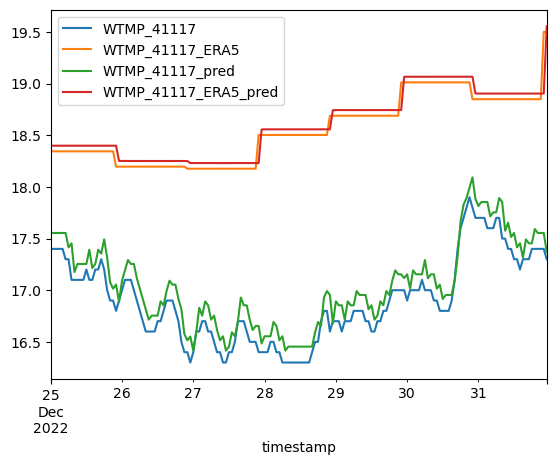

In [18]:
evaluation_1.plot(kind='line')

# Recurrent forecast

In [19]:
model.reset_states()
_ = model.predict(train_X_scaled, batch_size=1)

8590/8590 [==============================] - 3s 354us/step


In [20]:
# make a one-step forecast
# This function helps with reshaping.
def single_forecast(model, x):
    x = x.reshape(1, 1, len(x[0]))
    yhat = model.predict(x, verbose=0)
    return yhat

In [21]:
# Prepare data structure
prediction_2 = pd.DataFrame(test_y_scaled, columns=output_cols)
for col in output_cols:
    prediction_2[f"{col}_pred"] = 0

prediction_2

,WTMP_41117,WTMP_41117_ERA5,WTMP_41117_pred,WTMP_41117_ERA5_pred
0,-0.185185,-0.073070,0,0
1,-0.185185,-0.073070,0,0
2,-0.185185,-0.073070,0,0
3,-0.185185,-0.073070,0,0
4,-0.185185,-0.073070,0,0
...,...,...,...,...
163,-0.185185,-0.073070,0,0
164,-0.185185,-0.073070,0,0
165,-0.185185,-0.073070,0,0
166,-0.185185,0.744012,0,0


,WTMP_41117,WTMP_41117_ERA5,WTMP_41117_pred,WTMP_41117_ERA5_pred
0,-0.185185,-0.073070,-0.071253,-0.004634
1,-0.185185,-0.073070,-0.027906,-0.004546
2,-0.185185,-0.073070,-0.012367,-0.004374
3,-0.185185,-0.073070,-0.006845,-0.004310
4,-0.185185,-0.073070,-0.004887,-0.004287
...,...,...,...,...
163,-0.185185,-0.073070,-0.003815,-0.004274
164,-0.185185,-0.073070,-0.003815,-0.004274
165,-0.185185,-0.073070,-0.003815,-0.004274
166,-0.185185,0.744012,-0.003815,-0.004274


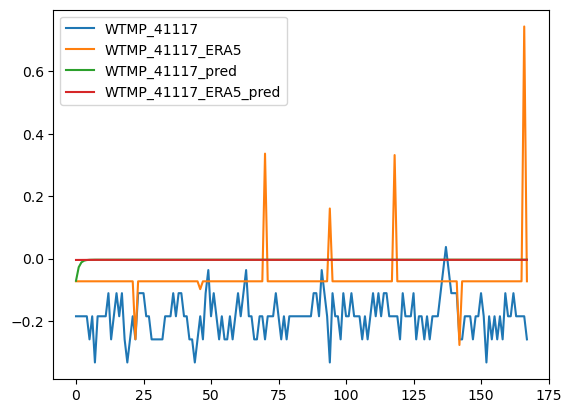

In [22]:
#Forecast a whole week
prev_obs = test_X_scaled[0]

for i, row in prediction_2.iterrows():
    yhat = single_forecast(model, prev_obs)
    prev_obs = yhat

    #Mapping of array index and df column name
    for j, element in enumerate(output_cols):
        prediction_2.at[i, f"{element}_pred"] =yhat[0,j]

prediction_2.plot(kind='line')
prediction_2

In [23]:
#Reverse differenciate
first_row = data.iloc[-len(yhat)-1]

yhat = prediction_2[[name + "_pred" for name in output_cols]].values
yhat_unscaled = DP.invert_scaling(yhat, SCALER)
yhat_true_value = DP.stationary_to_data(yhat_unscaled, first_row)

yhat_true_value_df = pd.DataFrame(yhat_true_value, columns=[name + "_pred" for name in output_cols])
yhat_true_value_df.set_index(data.tail(len(yhat)).index, inplace=True)

true_value = data.tail(len(yhat)+1).copy()

evaluation_2 = pd.concat([true_value, yhat_true_value_df], axis=1)
evaluation_2 = evaluation_2.iloc[STATIONARY_SHIFT:]
evaluation_2

,WTMP_41117,WTMP_41117_ERA5,WTMP_41117_pred,WTMP_41117_ERA5_pred
timestamp,,,,
2022-12-25 00:00:00,17.4,18.343939,17.553809,19.554759
2022-12-25 01:00:00,17.4,18.343939,17.766136,19.609408
2022-12-25 02:00:00,17.4,18.343939,17.999440,19.664195
2022-12-25 03:00:00,17.4,18.343939,18.240200,19.719033
2022-12-25 04:00:00,17.4,18.343939,18.483601,19.773889
...,...,...,...,...
2022-12-31 19:00:00,17.4,18.848540,57.413846,28.497623
2022-12-31 20:00:00,17.4,18.848540,57.658695,28.552489
2022-12-31 21:00:00,17.4,18.848540,57.903544,28.607355


In [24]:
wtmp_true = [col for col in evaluation_2.columns if col.startswith("WTMP")][0]

mae_2 = mean_absolute_error(evaluation_2[wtmp_true], evaluation_2[f"{wtmp_true}_pred"])
mse_2 = mean_squared_error(evaluation_2[wtmp_true], evaluation_2[f"{wtmp_true}_pred"])
print('MAE: ', mae_2)
print('MSE: ', mse_2)

MAE:  21.051172979213693
MSE:  580.9670931038343


<AxesSubplot:xlabel='timestamp'>

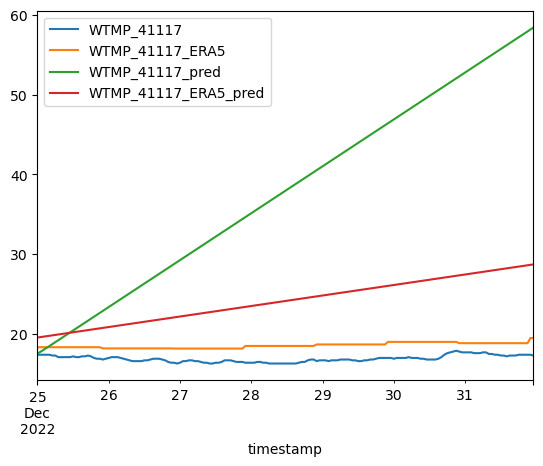

In [25]:
evaluation_2.plot(kind='line')

# SAVE

In [28]:
#Save Data About executed Test:

# Pickle file

#Convert model summary to string
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
model_summary = "\n".join(stringlist)

report = Experiment(
    name="Dataset_Testing",
    description="Stations that provide all files from 2013-2022 in GOM",

    stations = STATIONS,
    years = YEARS,
    nan_threshold=NAN_THRESHOLD,
    features=FEATURES,
    era5=ERA5,
    stationary_shift=STATIONARY_SHIFT,
    lag=LAG,
    n_test_hours=N_TEST_HOURS,

    #stationary=STATIONARY,
    scaler=SCALER,

    model_name = MODEL_NAME,
    model_summary=model_summary,

    one_shot_forecast = evaluation_1,
    recursive_forecast = evaluation_2
)


# open a file for writing in binary mode
with open(f'data/reports/{report.name}.pickle', 'wb') as f:
    # write the object to the file using pickle.dump()
    pickle.dump(report, f)